## BSA fitting using bins in Phi

The purpose of this file is to do BSA fitting for RGA data selected for Exclusive Rho using bins in phi instead of a MLM fit

$$\frac{d\sigma_+-d\sigma_-}{d\sigma_+ + d\sigma_- }  = \alpha \sin \phi$$
where 
$$ \alpha = \frac{\sqrt{2\epsilon (1-\epsilon)}F_{LU}^{\sin \phi}}{F_{UU}} $$

In [2]:
import ROOT
import os
import numpy as np
import uproot
import array

In [3]:
inputFiles = ["out/pippi0_fall2018_in_pass1/pippi0_fall2018_in_pass1.root","out/pippi0_spring2019_in_pass1/pippi0_spring2019_in_pass1.root"]

In [7]:

# Initialize empty lists to collect data
all_phi = []
all_z = []
all_hel = []
all_Mx = []
all_Mdiphoton = []
all_eps = []



for branches in uproot.iterate({f: "pippi0" for f in inputFiles}, ["phi", "z", "hel", "Mx", "Mdiphoton", "eps","Mh"], library="np"):

    all_phi.append(branches["phi"])
    all_z.append(branches["z"])
    all_hel.append(branches["hel"])
    all_Mx.append(branches["Mx"])
    all_Mdiphoton.append(branches["Mdiphoton"])
    all_eps.append(branches["eps"])


phi_vals = np.concatenate(all_phi)
z_vals = np.concatenate(all_z)
hel_vals = np.concatenate(all_hel)
Mx_vals = np.concatenate(all_Mx)
Mdiphoton_vals = np.concatenate(all_Mdiphoton)
eps_vals = np.concatenate(all_eps)


In [8]:
mask = (
    (branches["Mdiphoton"] > 0.115) & (branches["Mdiphoton"] < 0.16) &
    (branches["Mx"] > 0.85) & (branches["Mx"] < 1.05)
)

phi_vals = branches["phi"][mask]
z_vals = branches["z"][mask]
hel_vals = branches["hel"][mask]
eps_vals = branches["eps"][mask]
Mh_vals = branches["Mh"][mask]


In [9]:
print(len(phi_vals))

54624


In [10]:
fit = ROOT.TF1("fit","[0]*sin(x)",-3.14,3.14) #"name","fit_type",min,max
fit.SetLineWidth(4)
fit.SetLineColor(ROOT.kBlue)
fit.SetLineStyle(2)

In [11]:
def d_crystalball(x, par):
    t = (x[0] - par[1]) / par[2]
    if t < -par[3]:
        a = ROOT.TMath.Exp(-0.5*par[3]*par[3])
        b = par[3]/par[5]*(par[5]/par[3] - par[3] - t)
        return par[0]*a* ROOT.TMath.Power(b,-par[5])
    elif t > par[4]:
        a = ROOT.TMath.Exp(-0.5*par[4]*par[4])
        b = par[4]/par[6]*(par[6]/par[4] - par[4] + t)
        return par[0]*a* ROOT.TMath.Power(b,-par[6])
    else:
        return par[0] * ROOT.TMath.Exp(-0.5 * t * t)

def polynomial(x,par):
    return par[0] + par[1]*x[0] + par[2]*ROOT.TMath.Power(x[0],2) + par[3]*ROOT.TMath.Power(x[0],3)+ par[4]*ROOT.TMath.Power(x[0],4)

def total_func(x,par):
    par_cb = array.array('d',[par[0],par[1],par[2],par[3],par[4],par[5],par[6]])
    par_pol = array.array('d',[par[7],par[8],par[9],par[10],par[11]])
    fs=d_crystalball(x,array.array('d', par_cb))
    fm=polynomial(x,array.array('d', par_pol))
    return fs + fm

In [12]:
def fitToSin(h_neg,h_pos,zbnmin,zbnmax):
    num = h_pos.Clone("num")  
    
    
    num.Add(h_neg, -1)         # Asym = h_pos - h_neg
    
    denom = h_pos.Clone("denom")
    denom.Add(h_neg)      # denominator = h_neg + h_pos
    
    A.Divide(num,denom)    # Asym = (h_neg - h_pos) / (h_neg + h_pos)

    fit = ROOT.TF1("fit","[0]*sin(x)",zbnmin,zbnmax) 
    
    A.Fit("fit","R")

    c = ROOT.TCanvas()
    A.Draw()
    fit.Draw("same")
    c.Draw()

    print("ch2/ndf:",fit.GetChisquare()/fit.GetNDF())
    return c,fit.GetParameter(0)

In [13]:
#set initial parameters for fit
N = 500
mu = 0.8
sig = 0.06
alphal = 1.0
alphah = 0.9
nl = 2.8
nh = 1.5
p0 = -0.2
p1 = 0.25
p2 = 0.5
p3 = -0.75
p4 = 0.25
pars = [N,mu,sig,alphal,alphah,nl,nh,p0,p1,p2,p3,p4]
pars_sig = [N,mu,sig,alphal,alphah,nl,nh]

fit = ROOT.TF1("fit",total_func,0.4,1.7,12)
fit.SetLineWidth(4)
fit.SetLineColor(ROOT.kBlack)
fit.SetLineStyle(2)
fit.SetParameters(array.array('d',pars))
#fit.SetParLimits(0,0,1.5) #N
fit.SetParLimits(1,0.6,1) #mu

fit_sig = ROOT.TF1("fit_sig",d_crystalball,0.4,1.7,12)
fit_sig.SetLineWidth(4)
fit_sig.SetLineColor(ROOT.kBlack)
fit_sig.SetLineStyle(2)
fit_sig.SetParameters(array.array('d',pars_sig))

****************************************
         Invalid FitResult  (status = 3 )
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      3987.56
NDf                       =           32
NCalls                    =          273
p0                        =      71.4847   +/-   nan         
p1                        =     0.981415   +/-   nan          	 (limited)
p2                        =   0.00355627   +/-   nan         
p3                        =     0.841081   +/-   nan         
p4                        =      0.02899   +/-   nan         
p5                        = -1.82977e+08   +/-   nan         
p6                        =     -3.21846   +/-   nan         
p7                        =      6.35425   +/-   nan         
p8                        =     -26.6412   +/-   nan         
p9                        =      54.1991   +/-   nan         
p10                       =     -37.6261   +/-   nan         
p11                       =  

Warning in <TROOT::Append>: Replacing existing TH1: h_neg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file out/test/g0_0.png has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_neg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file out/test/g0_1.png has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_neg (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).


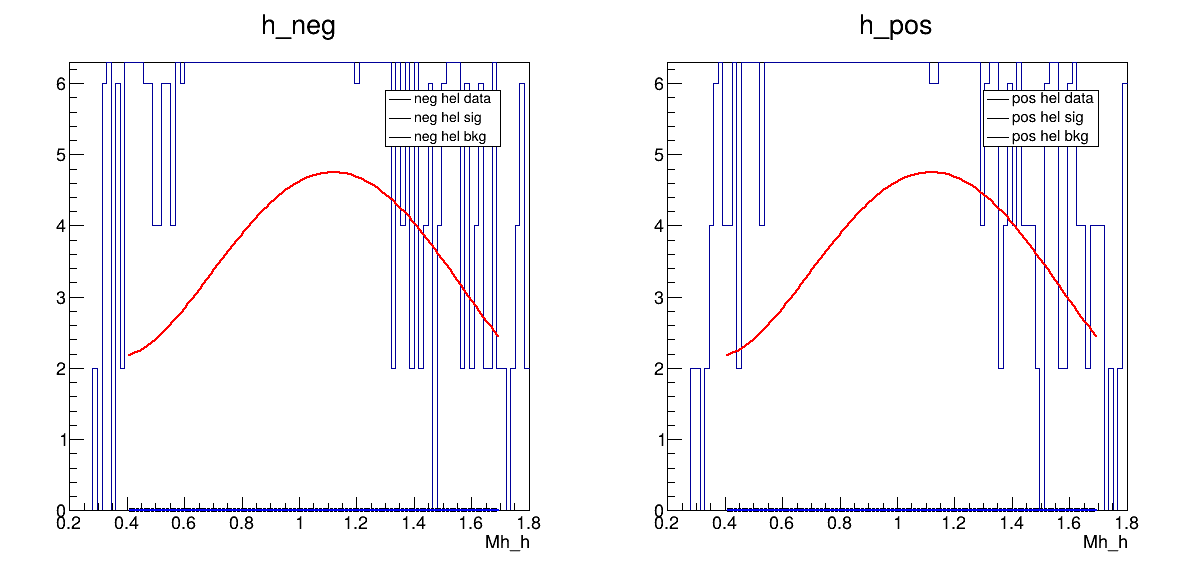

In [19]:
zbn_edges = [0.66, 0.74, 0.79, 0.82, 0.85, 0.88, 0.91, 0.93, 0.96, 1]
phibn_edges = np.linspace(-3.14,3.14,3)
ratio_list = []
zbn_centers = []
phibn_centers = []

#iterate through every z bin
for i in range(len(zbn_edges) - 1):
    zmin, zmax = zbn_edges[i], zbn_edges[i+1]
    zbin_mask = (z_vals > zmin) & (z_vals < zmax)

    phi_zbinned = phi_vals[zbin_mask]
    hel_zbinned = hel_vals[zbin_mask]
    eps_zbinned = eps_vals[zbin_mask]
    Mh_zbinned = Mh_vals[zbin_mask]

    #bin in phi to find Number of signal Rho events with respect to phi
    for j in range(len(phibn_edges)-1):
        phimin,phimax = phibn_edges[j],phibn_edges[j+1]
        phibin_mask = (phi_zbinned > phimin) & (phi_zbinned < phimax)

        Mh_phibinned = Mh_zbinned[phibin_mask]
        hel_phibinned = hel_zbinned[phibin_mask]
        
        #separate by helicity:
        Mh_neg = Mh_phibinned[hel_phibinned ==-1]
        Mh_pos = Mh_phibinned[hel_phibinned ==1]

        # Fill histograms
        h_neg = ROOT.TH1F("h_neg", "h_neg;Mh_h", 100, 0.2, 1.8)
        h_pos = ROOT.TH1F("h_pos", "h_pos;Mh_h", 100, 0.2, 1.8)
        for val in Mh_neg:
            h_neg.Fill(val)
        for val in Mh_pos:
            h_pos.Fill(val)

        ROOT.Math.MinimizerOptions.SetDefaultMaxFunctionCalls(6000)
    
        #fit to find number of sig events within this bin
        fit_result_neg = h_neg.Fit("fit","SR")
        params_neg = [fit.GetParameter(i) for i in range(12)]
        fit_result_pos = h_pos.Fit("fit","SR")
        params_pos = [fit.GetParameter(i) for i in range(12)]
    
        #define functions based on parameters
        cb_func_neg = ROOT.TF1("cb_func_neg",d_crystalball,0.4,1.7,7)
        cb_func_neg.SetParameters(params_neg[0],params_neg[1],params_neg[2],params_neg[3],params_neg[4],params_neg[5],params_neg[6])
        cb_func_neg.SetLineColor(ROOT.kBlue)
    
        pol4_func_neg = ROOT.TF1("pol4_func_neg",polynomial,0.4,1.7,5)
        pol4_func_neg.SetParameters(params_neg[7],params_neg[8],params_neg[9],params_neg[10],params_neg[11])
        pol4_func_neg.SetLineColor(ROOT.kRed)

        cb_func_pos = ROOT.TF1("cb_func_pos",d_crystalball,0.4,1.7,7)
        cb_func_pos.SetParameters(params_pos[0],params_pos[1],params_pos[2],params_pos[3],params_pos[4],params_pos[5],params_pos[6])
        cb_func_pos.SetLineColor(ROOT.kBlue)
    
        pol4_func_pos = ROOT.TF1("pol4_func_pos",polynomial,0.4,1.7,5)
        pol4_func_pos.SetParameters(params_pos[7],params_pos[8],params_pos[9],params_pos[10],params_pos[11])
        pol4_func_pos.SetLineColor(ROOT.kRed)

        c = ROOT.TCanvas("c","c",1200,600)
        leg_neg = ROOT.TLegend(0.65,0.75,0.85,0.85)
        leg_neg.AddEntry("h_neg","neg hel data","l")
        leg_neg.AddEntry("cb_func_neg","neg hel sig","l")
        leg_neg.AddEntry("pol4_func_pos","neg hel bkg","l")

        leg_pos = ROOT.TLegend(0.65,0.75,0.85,0.85)
        leg_pos.AddEntry("h_pos","pos hel data","l")
        leg_pos.AddEntry("cb_func_pos","pos hel sig","l")
        leg_pos.AddEntry("pol4_func_pos","pos hel bkg","l")

        h_neg.SetStats(0)
        h_pos.SetStats(0)

        c.Divide(2)
        c.cd(1)
        h_neg.Draw()
        cb_func_neg.Draw("SAME")
        pol4_func_neg.Draw("SAME")
        leg_neg.Draw()
        c.cd(2)
        h_pos.Draw()
        cb_func_pos.Draw("SAME")
        pol4_func_pos.Draw("SAME")
        leg_pos.Draw()
        c.Draw()
        c.SaveAs(f"out/test/g{i}_{j}.png")
        

        #integrate signal curve to find the total number of rho events of each helicity

        #find proper ratio of helicity cross sections (scaled by polarization)

        #save to a list for plotting with respect to sin phi to fit linearly


    # Fit and calculate asymmetry
    #c, A_val = fitToSin(h_neg, h_pos, -3.14, 3.14)

    #eps_avg = np.mean(eps_zbinned)
    #depolarization = np.sqrt(2 * eps_avg * (1 - eps_avg))
    #ratio_list.append(A_val / depolarization)
    #zbn_centers.append((zmin + zmax) / 2)

    

In [15]:
x = 
y = 
x = np.zeroeslike(x)
y = np.zeroeslike(y)

gr = ROOT.TGraphErrors(len(x),x,y,xerr,yerr)

SyntaxError: invalid syntax (3987745039.py, line 1)

In [ ]:
RunPlotting(ratio_list,zbn_centers,
                "RGA_inbending", "F_{LU}^{sin#phi}/F_{UU}",
                "z")

In [ ]:
print(len(zbn_centers),len(ratio_list))